<a href="https://www.kaggle.com/code/patilaakash619/spotify-streaming-success-predictor?scriptVersionId=224852060" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="1"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 1: Import Libraries 🛠️</h2>
</div>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# For modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

# For warnings
import warnings
warnings.filterwarnings('ignore')

# Set styling for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

<a id="2"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 2: Data Loading and Initial Exploration 📊</h2>
</div>

In [2]:
df = pd.read_csv("/kaggle/input/spotify-dataset-for-self-practise/spotify_2023.csv", encoding="ISO-8859-1")

<a id="3"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 3: Data Understanding and Summary Statistics 📈</h2>
</div>

In [3]:
# Display basic information about the dataset
print("Data Info:")
df.info()

# Summary statistics
print("\nNumerical Features Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check unique values for categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
print("\nUnique values in categorical columns:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non

<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 4: Data Cleaning and Preprocessing 🧹</h2>
</div>

In [4]:
# Create a copy of the dataframe to avoid modifying the original
df_clean = df.copy()

# Let's examine the problematic rows first
print("Sample of 'streams' column values:")
print(df_clean['streams'].head(10).tolist())

# Check for problematic rows in streams
problematic_rows = df_clean[~df_clean['streams'].str.replace(',', '').str.isdigit()]
print(f"\nNumber of problematic rows in 'streams' column: {len(problematic_rows)}")

if len(problematic_rows) > 0:
    print("Sample of problematic rows:")
    print(problematic_rows[['track_name', 'artist(s)_name', 'streams']].head())
    
    # Filter out problematic rows
    df_clean = df_clean[df_clean['streams'].str.replace(',', '').str.isdigit()]
    print(f"\nDataFrame shape after filtering: {df_clean.shape}")

# Now proceed with the conversions
# 1. Convert streams to numeric values
df_clean['streams'] = df_clean['streams'].str.replace(',', '').astype(float)

# 2. Convert deezer_playlists to numeric
# First check if there are non-numeric values with commas
print("\nChecking 'in_deezer_playlists' column...")
sample_deezer = df_clean['in_deezer_playlists'].head(10).tolist()
print(f"Sample values: {sample_deezer}")

# Remove commas and convert
df_clean['in_deezer_playlists'] = df_clean['in_deezer_playlists'].str.replace(',', '').astype(float)

# 3. Convert in_shazam_charts to numeric, fill missing values with 0
df_clean['in_shazam_charts'] = df_clean['in_shazam_charts'].fillna('0')

# Check for issues in in_shazam_charts
print("\nChecking 'in_shazam_charts' column...")
sample_shazam = df_clean['in_shazam_charts'].head(10).tolist()
print(f"Sample values: {sample_shazam}")

# Let's see if there are commas in this field
has_commas = df_clean['in_shazam_charts'].str.contains(',').any()
print(f"Contains commas: {has_commas}")

# Handle all potential issues
df_clean['in_shazam_charts'] = df_clean['in_shazam_charts'].str.replace(',', '')

# Check if all values are numeric after removing commas
is_numeric = df_clean['in_shazam_charts'].str.isdigit().all()
print(f"All values are numeric: {is_numeric}")

if not is_numeric:
    # Find non-numeric values
    non_numeric = df_clean[~df_clean['in_shazam_charts'].str.isdigit()]
    print(f"Number of non-numeric values: {len(non_numeric)}")
    if len(non_numeric) > 0:
        print("Sample of non-numeric values:")
        print(non_numeric[['track_name', 'in_shazam_charts']].head())
        
        # Extract digits or set to 0
        df_clean['in_shazam_charts'] = df_clean['in_shazam_charts'].str.extract('(\d+)', expand=False).fillna('0')

# Now convert to numeric
df_clean['in_shazam_charts'] = df_clean['in_shazam_charts'].astype(float)

# 4. Fill missing key values with 'Unknown'
df_clean['key'] = df_clean['key'].fillna('Unknown')

# 5. Create a release_date column
df_clean['release_date'] = pd.to_datetime(df_clean[['released_year', 'released_month', 'released_day']].assign(
    released_day=df_clean.released_day.clip(upper=28)  # Handle invalid dates like Feb 30
).rename(columns={'released_year': 'year', 'released_month': 'month', 'released_day': 'day'}))

# 6. Create release day of week feature
df_clean['release_day_name'] = df_clean['release_date'].dt.day_name()

# 7. Create a decade feature
df_clean['decade'] = (df_clean['released_year'] // 10) * 10

# 8. Energy level categorization
def categorize_energy(energy):
    if energy < 40:
        return "Low"
    elif energy < 70:
        return "Medium"
    else:
        return "High"

df_clean['energy_category'] = df_clean['energy_%'].apply(categorize_energy)

# 9. Create popularity metrics
# Normalize streams to a 0-100 scale for simplicity
max_streams = df_clean['streams'].max()
df_clean['popularity_score'] = (df_clean['streams'] / max_streams) * 100

def categorize_popularity(score):
    if score < 1:
        return "Low"
    elif score < 10:
        return "Medium"
    else:
        return "High"

df_clean['popularity_category'] = df_clean['popularity_score'].apply(categorize_popularity)

# Check the updated dataframe
print("\nCleaned DataFrame shape:", df_clean.shape)
print("\nUpdated columns:")
print(df_clean.columns.tolist())
print("\nSample of cleaned data:")
df_clean[['track_name', 'artist(s)_name', 'streams', 'release_date', 
          'decade', 'energy_category', 'popularity_category']].head()

Sample of 'streams' column values:
['141381703', '133716286', '140003974', '800840817', '303236322', '183706234', '725980112', '58149378', '95217315', '553634067']

Number of problematic rows in 'streams' column: 1
Sample of problematic rows:
                              track_name     artist(s)_name  \
574  Love Grows (Where My Rosemary Goes)  Edison Lighthouse   

                                               streams  
574  BPM110KeyAModeMajorDanceability53Valence75Ener...  

DataFrame shape after filtering: (952, 24)

Checking 'in_deezer_playlists' column...
Sample values: ['45', '58', '91', '125', '87', '88', '43', '30', '48', '66']

Checking 'in_shazam_charts' column...
Sample values: ['826', '382', '949', '548', '425', '946', '418', '194', '953', '339']
Contains commas: True
All values are numeric: True

Cleaned DataFrame shape: (952, 30)

Updated columns:
['track_name', 'artist(s)_name', 'artist_count', 'released_year', 'released_month', 'released_day', 'in_spotify_playlists',

,track_name,artist(s)_name,streams,release_date,decade,energy_category,popularity_category
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",141381703.0,2023-07-14,2020,High,Medium
1,LALA,Myke Towers,133716286.0,2023-03-23,2020,High,Medium
2,vampire,Olivia Rodrigo,140003974.0,2023-06-28,2020,Medium,Medium
3,Cruel Summer,Taylor Swift,800840817.0,2019-08-23,2010,High,High
4,WHERE SHE GOES,Bad Bunny,303236322.0,2023-05-18,2020,High,Medium


<a id="5"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 5: Exploratory Data Analysis - Univariate Analysis 🔍</h2>
</div>

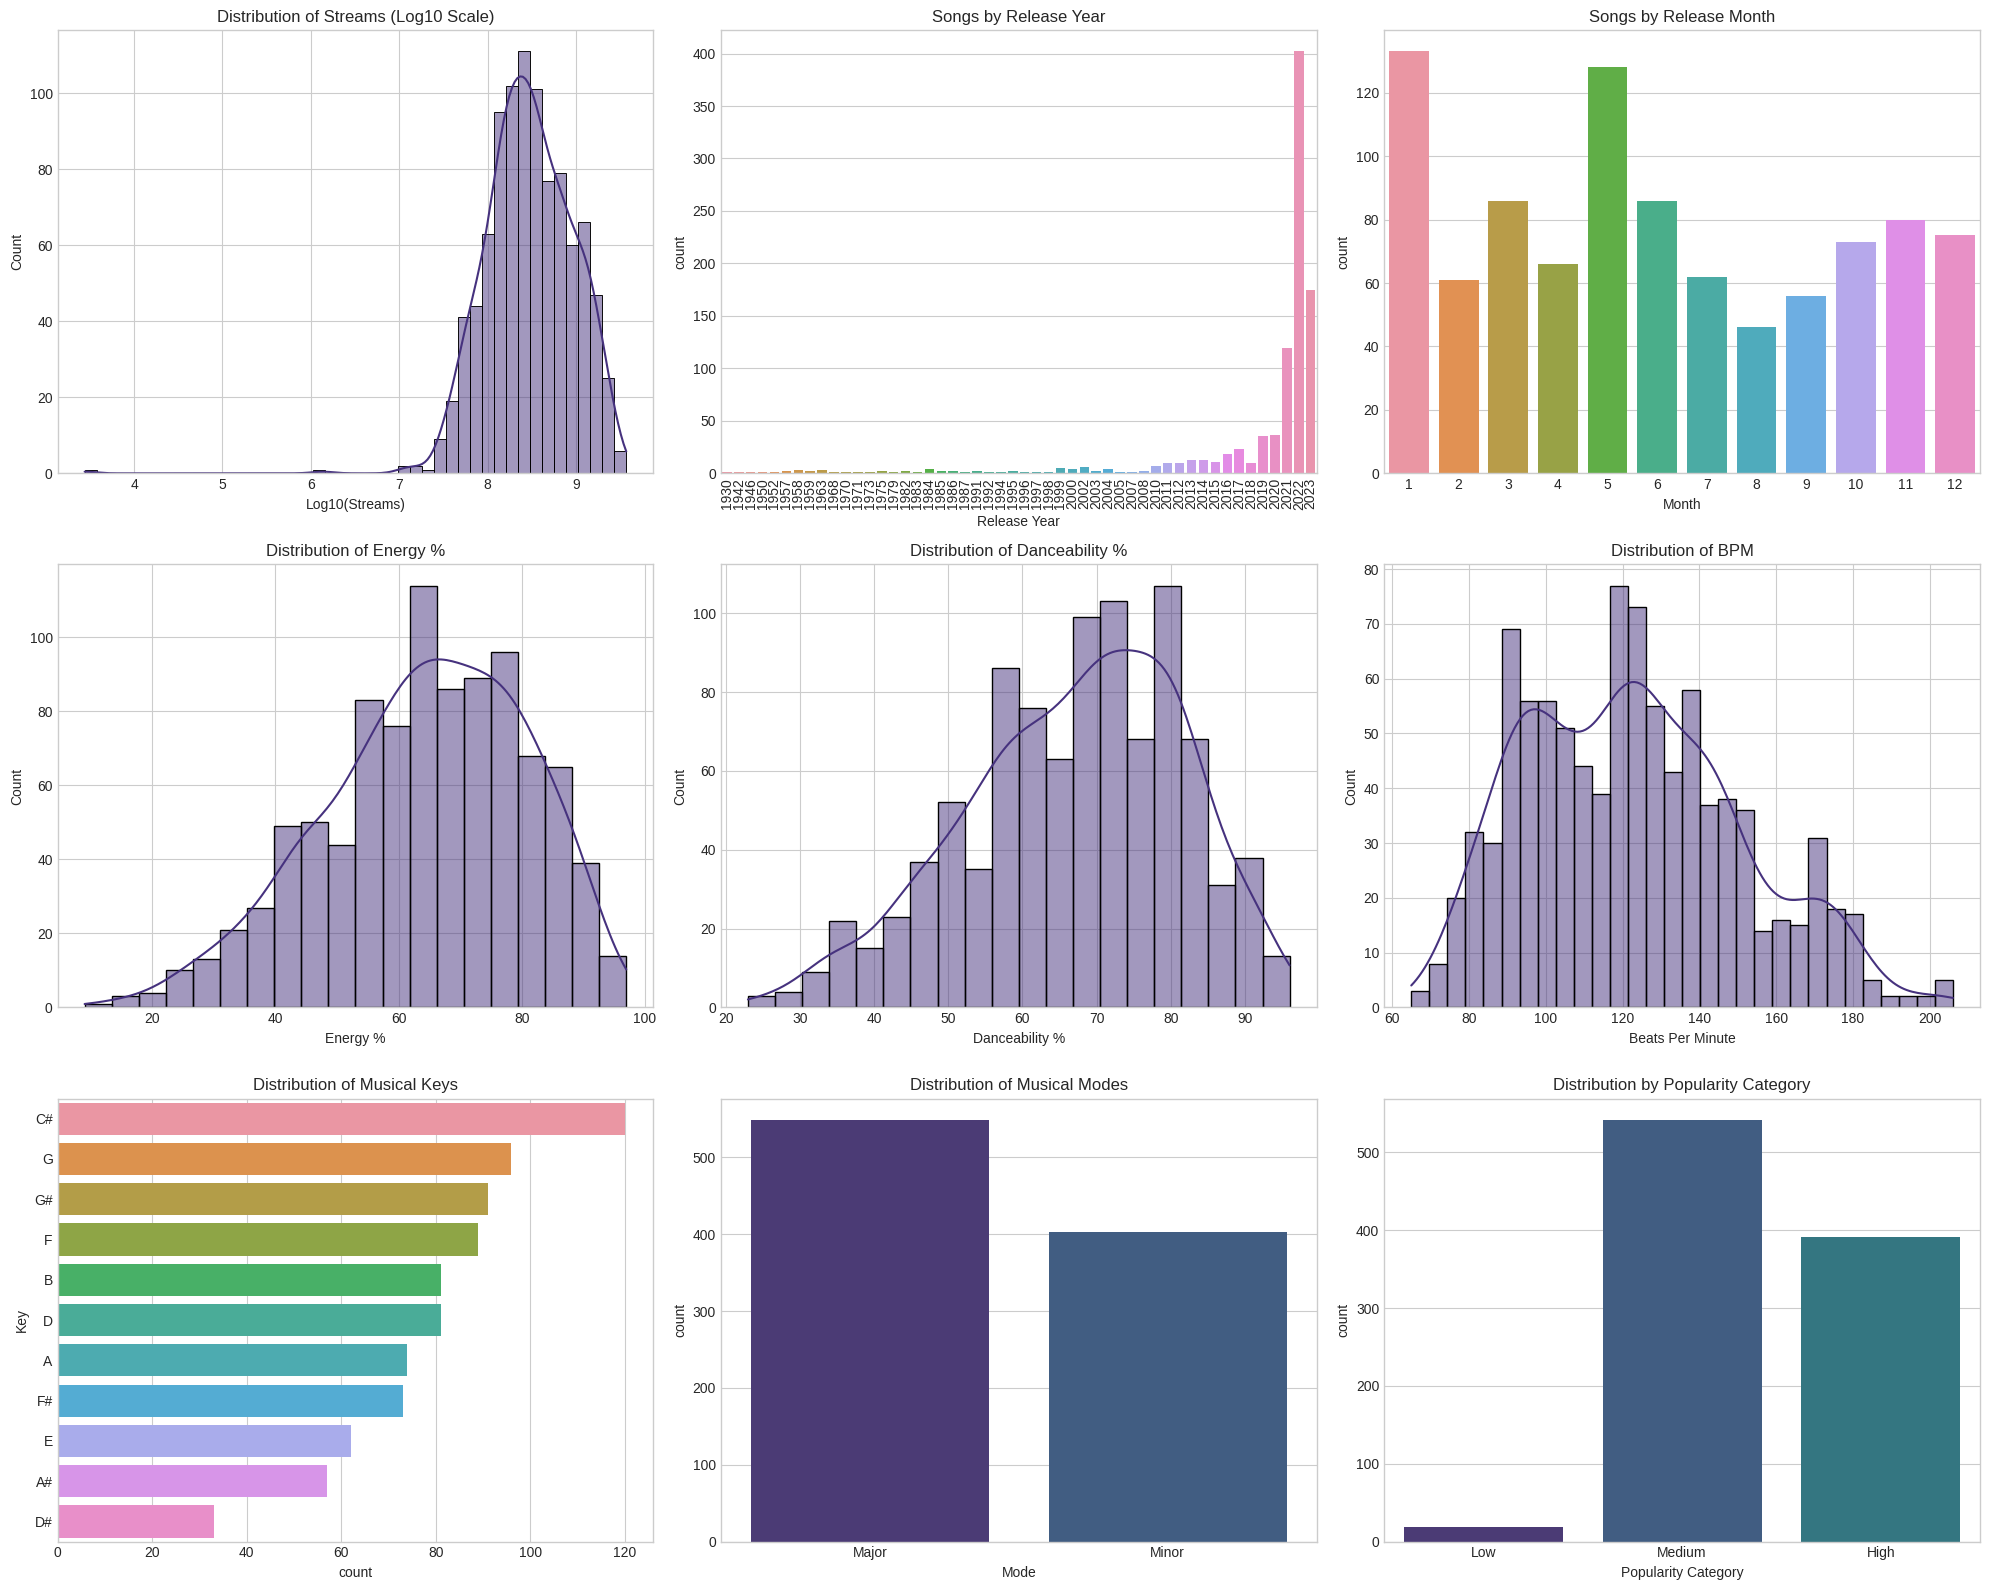

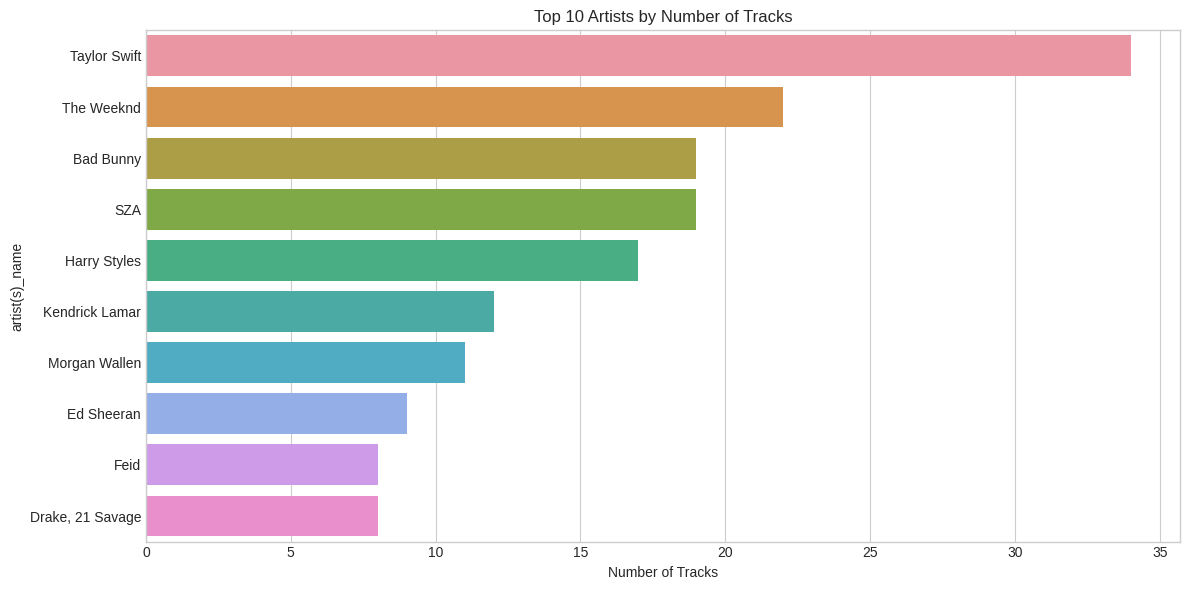

In [5]:
# Set up the figure size
plt.figure(figsize=(20, 16))

# 1. Distribution of streams (log-transformed for better visualization)
plt.subplot(3, 3, 1)
sns.histplot(np.log10(df_clean['streams']), kde=True)
plt.title('Distribution of Streams (Log10 Scale)')
plt.xlabel('Log10(Streams)')

# 2. Distribution of release years
plt.subplot(3, 3, 2)
sns.countplot(data=df_clean, x='released_year', order=sorted(df_clean['released_year'].unique()))
plt.title('Songs by Release Year')
plt.xticks(rotation=90)
plt.xlabel('Release Year')

# 3. Distribution of release months
plt.subplot(3, 3, 3)
sns.countplot(data=df_clean, x='released_month', order=range(1, 13))
plt.title('Songs by Release Month')
plt.xlabel('Month')

# 4. Distribution of energy percentages
plt.subplot(3, 3, 4)
sns.histplot(df_clean['energy_%'], kde=True, bins=20)
plt.title('Distribution of Energy %')
plt.xlabel('Energy %')

# 5. Distribution of danceability percentages
plt.subplot(3, 3, 5)
sns.histplot(df_clean['danceability_%'], kde=True, bins=20)
plt.title('Distribution of Danceability %')
plt.xlabel('Danceability %')

# 6. Distribution of BPM (tempo)
plt.subplot(3, 3, 6)
sns.histplot(df_clean['bpm'], kde=True, bins=30)
plt.title('Distribution of BPM')
plt.xlabel('Beats Per Minute')

# 7. Distribution of Musical Keys
plt.subplot(3, 3, 7)
key_order = [k for k in df_clean['key'].value_counts().index.tolist() if k != 'Unknown']
sns.countplot(data=df_clean[df_clean['key'] != 'Unknown'], y='key', order=key_order)
plt.title('Distribution of Musical Keys')
plt.ylabel('Key')

# 8. Distribution of Modes (Major/Minor)
plt.subplot(3, 3, 8)
sns.countplot(data=df_clean, x='mode')
plt.title('Distribution of Musical Modes')
plt.xlabel('Mode')

# 9. Distribution by Popularity Category
plt.subplot(3, 3, 9)
sns.countplot(data=df_clean, x='popularity_category', order=['Low', 'Medium', 'High'])
plt.title('Distribution by Popularity Category')
plt.xlabel('Popularity Category')

plt.tight_layout()
plt.show()

# 10. Top 10 Artists by Number of Tracks
plt.figure(figsize=(12, 6))
top_artists = df_clean['artist(s)_name'].value_counts().head(10)
sns.barplot(x=top_artists.values, y=top_artists.index)
plt.title('Top 10 Artists by Number of Tracks')
plt.xlabel('Number of Tracks')
plt.tight_layout()
plt.show()

<a id="6"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 6: Feature Engineering 🛠️</h2>
</div>

In [6]:
# Create a copy for modeling
df_model = df_clean.copy()

# First, let's check for columns that might contain problematic string values
print("Data types in the cleaned dataframe:")
print(df_model.dtypes)

# Examine object columns to understand what we're dealing with
object_columns = df_model.select_dtypes(include=['object']).columns
print("\nObject columns:", object_columns.tolist())

for col in object_columns:
    print(f"\nUnique values in {col}:")
    print(df_model[col].unique()[:5])  # Show first 5 unique values

# Let's handle categorical columns before proceeding
# 1. Convert categorical variables to one-hot encoding
# Keep track of columns we want to use for analysis
columns_to_drop = ['track_name', 'artist(s)_name', 'release_date', 'popularity_category', 'streams']

# One-hot encode categorical columns
df_model = pd.get_dummies(
    df_model,
    columns=['mode', 'energy_category', 'key', 'release_day_name'],
    drop_first=False
)

# Now proceed with feature engineering on numeric data
# 2. Create interaction features
df_model['energy_x_danceability'] = df_model['energy_%'] * df_model['danceability_%'] / 100
df_model['acousticness_x_instrumentalness'] = df_model['acousticness_%'] * df_model['instrumentalness_%'] / 100
df_model['spotify_apple_ratio'] = df_model['in_spotify_playlists'] / (df_model['in_apple_playlists'] + 1)  # +1 to avoid division by zero

# 3. Create time-based features
df_model['days_since_release'] = (pd.Timestamp('2023-12-31') - df_model['release_date']).dt.days
df_model['is_recent'] = (df_model['released_year'] >= 2020).astype(int)

# 4. Create features for seasonality
df_model['is_summer_release'] = df_model['released_month'].isin([6, 7, 8]).astype(int)
df_model['is_winter_release'] = df_model['released_month'].isin([12, 1, 2]).astype(int)

# 5. Log transform highly skewed features
skewed_cols = ['streams', 'in_spotify_playlists', 'in_apple_playlists', 'days_since_release']
for col in skewed_cols:
    df_model[f'{col}_log'] = np.log1p(df_model[col])

# 6. Create artist features
# Average streams per artist
artist_mean_streams = df_model.groupby('artist(s)_name')['streams'].mean()
df_model['artist_avg_streams'] = df_model['artist(s)_name'].map(artist_mean_streams)

# Artist popularity tier
def categorize_artist_popularity(streams):
    if streams < 1e6:  # less than 1 million
        return 0  # Emerging
    elif streams < 1e7:  # less than 10 million
        return 1  # Established
    elif streams < 1e8:  # less than 100 million
        return 2  # Popular
    else:  # 100 million+
        return 3  # Superstar

df_model['artist_popularity_tier'] = df_model['artist_avg_streams'].apply(categorize_artist_popularity)

# 7. Audio features ratios
df_model['energy_danceability_ratio'] = df_model['energy_%'] / (df_model['danceability_%'] + 1)
df_model['valence_energy_ratio'] = df_model['valence_%'] / (df_model['energy_%'] + 1)

# 8. Create audio feature percentiles
for feature in ['danceability_%', 'energy_%', 'acousticness_%', 'valence_%']:
    df_model[f'{feature}_percentile'] = df_model[feature].rank(pct=True) * 100

# 9. Feature for collaborative songs
df_model['is_collab'] = (df_model['artist_count'] > 1).astype(int)

# 10. Create combined playlist reach
df_model['total_playlist_reach'] = (df_model['in_spotify_playlists'] + 
                                    df_model['in_apple_playlists'] + 
                                    df_model['in_deezer_playlists'])

# 11. Features for chart presence
df_model['total_chart_presence'] = (df_model['in_spotify_charts'] + 
                                   df_model['in_apple_charts'] + 
                                   df_model['in_deezer_charts'] +
                                   df_model['in_shazam_charts'])

# 12. Create target variables
# For regression: log-transformed streams
df_model['target_streams_log'] = np.log1p(df_model['streams'])

# For classification: popularity category
popularity_map = {'Low': 0, 'Medium': 1, 'High': 2}
df_model['target_popularity'] = df_model['popularity_category'].map(popularity_map)

# Drop non-numeric columns for modeling
# This includes the original string columns we don't need for modeling
df_model_numeric = df_model.drop(columns=columns_to_drop)

# Check that we only have numeric columns
print("\nData types after feature engineering:")
print(df_model_numeric.dtypes.value_counts())

# Verify that there are no object columns left
if 'object' in df_model_numeric.dtypes.values:
    print("\nWarning: Object columns still present!")
    object_cols = df_model_numeric.select_dtypes(include=['object']).columns
    print("Object columns:", object_cols.tolist())
else:
    print("\nAll columns are numeric now.")

print("Feature engineering complete. New shape:", df_model_numeric.shape)
print("\nSample of new features:")
new_features = ['energy_x_danceability', 'days_since_release', 'is_recent', 
                'artist_popularity_tier', 'is_collab', 'total_playlist_reach', 
                'total_chart_presence']
print(df_model_numeric[new_features].head())

# Correlation with target
correlation_with_streams = df_model_numeric.corr()['target_streams_log'].sort_values(ascending=False)
print("\nTop 10 features with highest correlation to log streams:")
print(correlation_with_streams.head(11))  # 11 because the target itself is included

Data types in the cleaned dataframe:
track_name                      object
artist(s)_name                  object
artist_count                     int64
released_year                    int64
released_month                   int64
released_day                     int64
in_spotify_playlists             int64
in_spotify_charts                int64
streams                        float64
in_apple_playlists               int64
in_apple_charts                  int64
in_deezer_playlists            float64
in_deezer_charts                 int64
in_shazam_charts               float64
bpm                              int64
key                             object
mode                            object
danceability_%                   int64
valence_%                        int64
energy_%                         int64
acousticness_%                   int64
instrumentalness_%               int64
liveness_%                       int64
speechiness_%                    int64
release_date            dat

<a id="7"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 7: Correlation Analysis and Feature Selection 📊</h2>
</div>

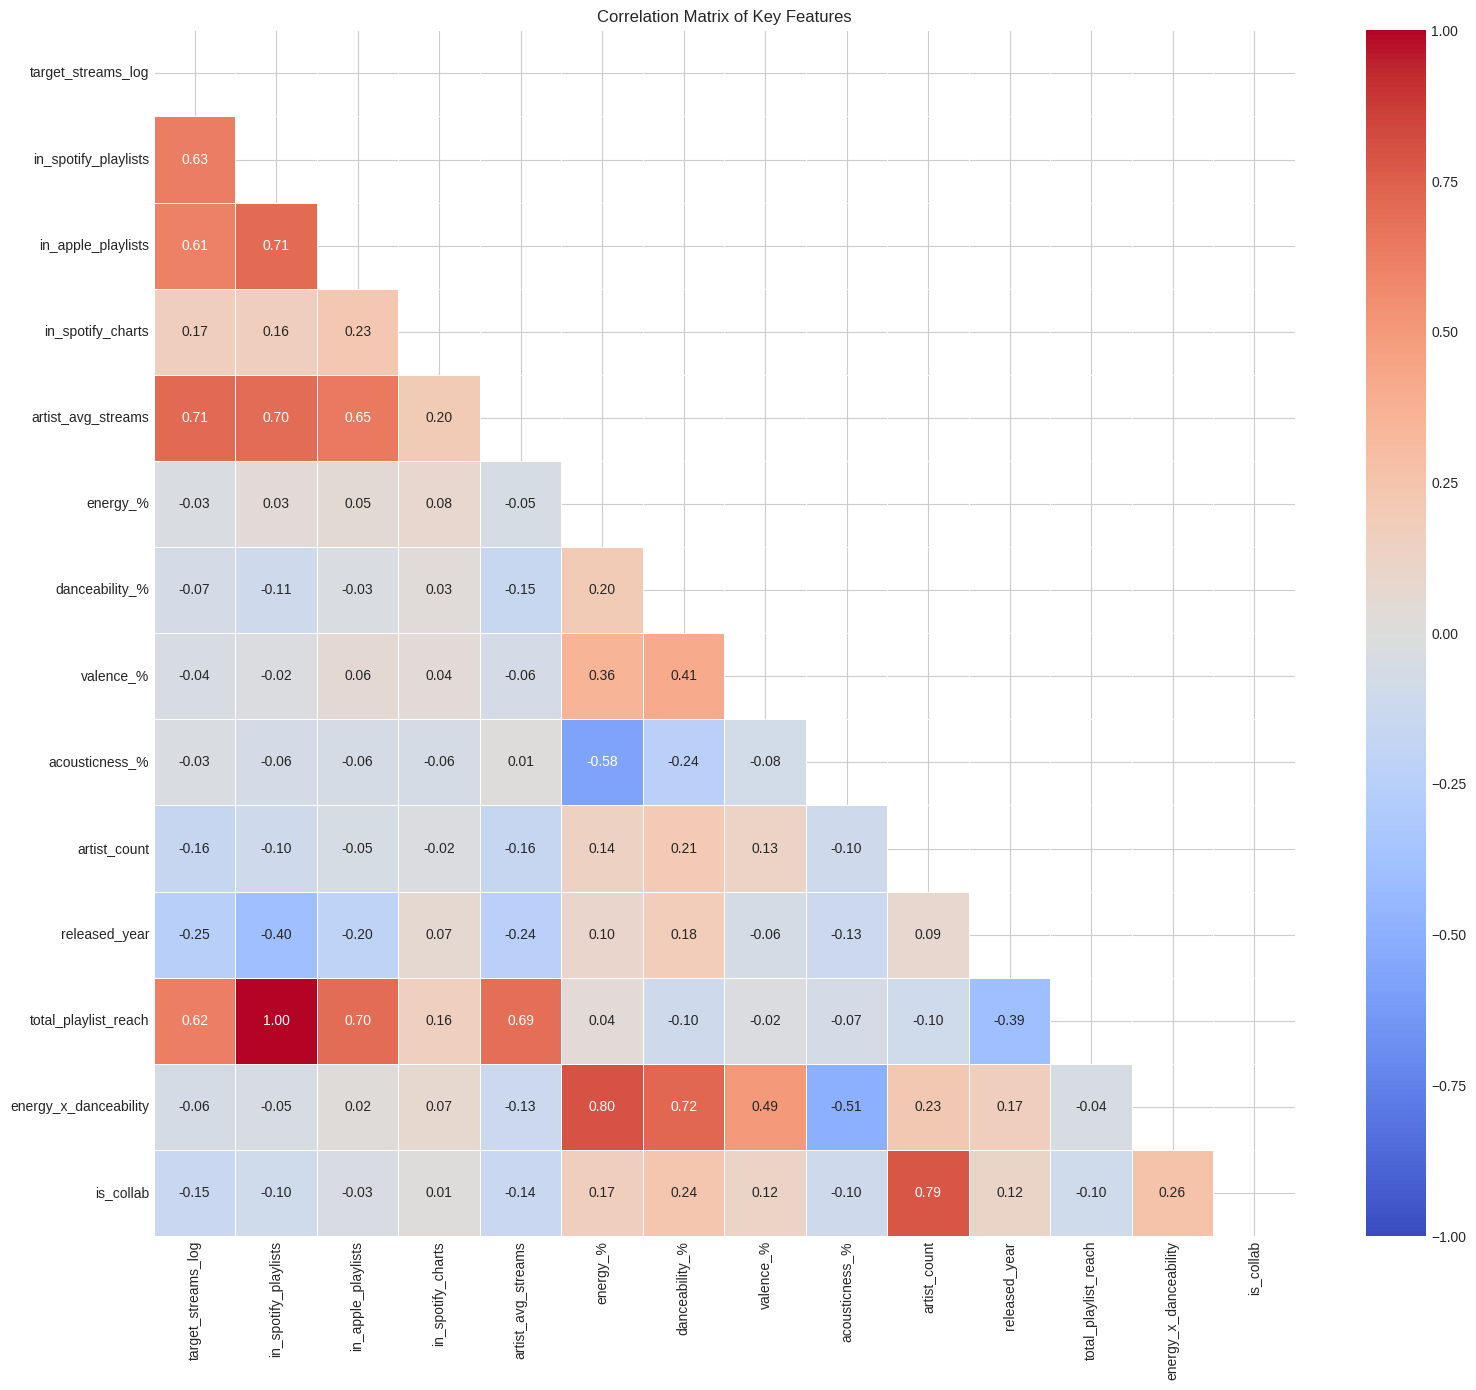

Top 15 features by correlation with log streams:
target_streams_log          1.000000
streams_log                 1.000000
target_popularity           0.823601
popularity_score            0.814736
in_spotify_playlists_log    0.787124
artist_avg_streams          0.713452
in_spotify_playlists        0.632161
total_playlist_reach        0.621108
in_apple_playlists          0.613879
in_apple_playlists_log      0.607685
days_since_release_log      0.565111
artist_popularity_tier      0.536123
is_recent                   0.492262
in_deezer_playlists         0.434695
in_apple_charts             0.270380
decade                      0.270180
Name: target_streams_log, dtype: float64

Highly correlated feature pairs (|r| > 0.8):
1. released_year and decade: 0.9852
2. released_year and days_since_release: -0.9996
3. released_year and days_since_release_log: -0.8063
4. in_spotify_playlists and in_deezer_playlists: 0.8264
5. in_spotify_playlists and total_playlist_reach: 0.9976
6. in_deezer_playlist

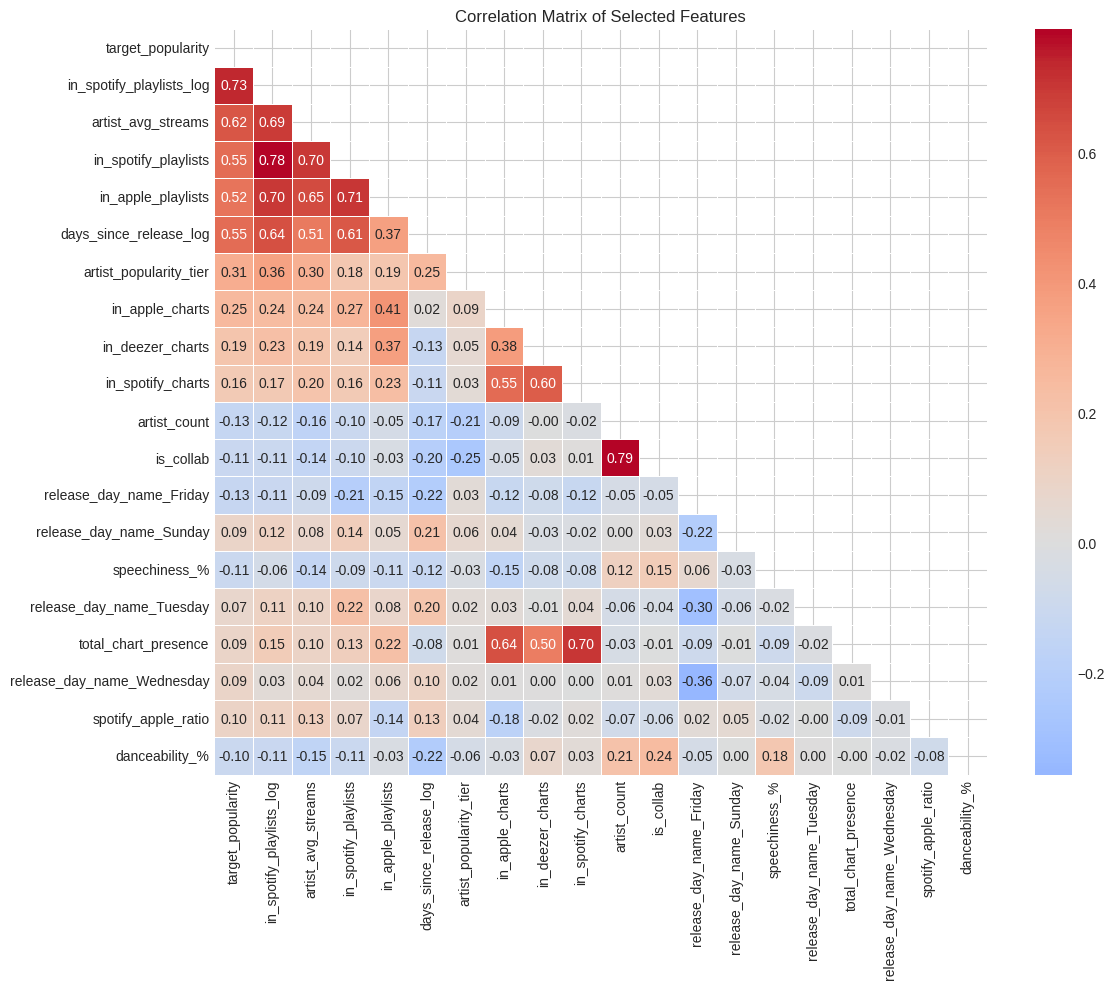


Final feature set shape: (952, 20)


In [7]:
# 1. Correlation matrix and heatmap visualization
plt.figure(figsize=(16, 14))
corr_matrix = df_model_numeric.corr()

# Create a mask for the upper triangle
mask = np.triu(corr_matrix)

# Draw the heatmap with a subset of interesting features
# Select a subset of features to visualize to avoid overcrowding
interesting_features = [
    'target_streams_log', 'in_spotify_playlists', 'in_apple_playlists', 
    'in_spotify_charts', 'artist_avg_streams', 'energy_%', 'danceability_%',
    'valence_%', 'acousticness_%', 'artist_count', 'released_year', 
    'total_playlist_reach', 'energy_x_danceability', 'is_collab'
]

# Use a subset correlation matrix for visualization
subset_corr = corr_matrix.loc[interesting_features, interesting_features]
subset_mask = np.triu(subset_corr)

# Draw the heatmap
sns.heatmap(subset_corr, mask=subset_mask, cmap='coolwarm', center=0, 
            linewidths=0.5, annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Key Features')
plt.tight_layout()
plt.show()

# 2. Select most important features for modeling based on correlation with target
target_corr = corr_matrix['target_streams_log'].abs().sort_values(ascending=False)
print("Top 15 features by correlation with log streams:")
print(target_corr.head(16))  # 16 because the target itself is included

# 3. Check for multicollinearity
threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print("\nHighly correlated feature pairs (|r| > 0.8):")
for i, pair in enumerate(high_corr_pairs[:15], 1):  # Show top 15 pairs
    print(f"{i}. {pair[0]} and {pair[1]}: {pair[2]:.4f}")

# 4. Select predictive features for modeling
# Remove highly correlated features and keep the one with higher correlation to target
features_to_keep = []
seen_features = set()

for feature in target_corr.index:
    # Skip if feature is the target itself or a variation of the target
    if feature in ['target_streams_log', 'streams', 'streams_log', 'popularity_score']:
        continue
    
    # Skip if the feature is highly correlated with another feature we're already keeping
    skip = False
    for kept_feature in features_to_keep:
        if abs(corr_matrix.loc[feature, kept_feature]) > threshold and feature != kept_feature:
            skip = True
            break
    
    if not skip and feature not in seen_features:
        features_to_keep.append(feature)
        seen_features.add(feature)
        
        # Also exclude variations of the same feature
        for col in corr_matrix.columns:
            if feature in col and feature != col:
                seen_features.add(col)

# Keep top 20 features
features_to_keep = features_to_keep[:20]

print("\nSelected features for modeling:")
for i, feature in enumerate(features_to_keep, 1):
    corr_value = target_corr[feature]
    print(f"{i}. {feature}: {corr_value:.4f}")

# 5. Create a correlation plot for the selected features
plt.figure(figsize=(12, 10))
selected_corr = corr_matrix.loc[features_to_keep, features_to_keep]
selected_mask = np.triu(selected_corr)
sns.heatmap(selected_corr, mask=selected_mask, cmap='coolwarm', center=0, 
            linewidths=0.5, annot=True, fmt='.2f')
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
plt.show()

# 6. Prepare final feature set for modeling
X = df_model_numeric[features_to_keep]
y_reg = df_model_numeric['target_streams_log']
y_class = df_model_numeric['target_popularity']

print("\nFinal feature set shape:", X.shape)

<a id="8"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 8: Train-Test Split and Data Preprocessing 🔄</h2>
</div>

Training set shape: (761, 20)
Testing set shape: (191, 20)
Processed training set shape: (761, 20)

Summary of processed training data:
Mean of each feature (should be close to 0):
[7.23614481e-17 2.70771870e-16 6.18573669e-17 5.31039660e-17
 7.58628085e-17]

Standard deviation of each feature (should be close to 1):
[1. 1. 1. 1. 1.]


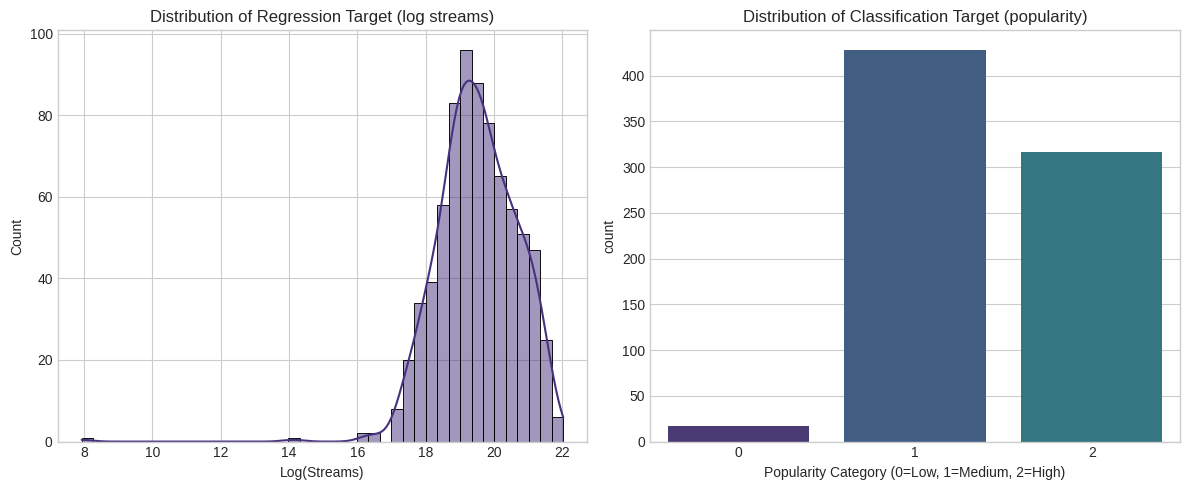

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 1. Split the data for both regression and classification tasks
X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
    X, y_reg, y_class, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# 2. Create preprocessing pipeline for numerical features
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 3. Apply preprocessing to training data
X_train_processed = preprocessor.fit_transform(X_train)
print(f"Processed training set shape: {X_train_processed.shape}")

# 4. Show summary of the data after preprocessing
print("\nSummary of processed training data:")
processed_mean = np.mean(X_train_processed, axis=0)
processed_std = np.std(X_train_processed, axis=0)

print("Mean of each feature (should be close to 0):")
print(processed_mean[:5])  # Show first 5 features

print("\nStandard deviation of each feature (should be close to 1):")
print(processed_std[:5])  # Show first 5 features

# 5. Check the target variables distribution
plt.figure(figsize=(12, 5))

# Regression target distribution
plt.subplot(1, 2, 1)
sns.histplot(y_reg_train, kde=True)
plt.title('Distribution of Regression Target (log streams)')
plt.xlabel('Log(Streams)')

# Classification target distribution
plt.subplot(1, 2, 2)
sns.countplot(x=y_class_train)
plt.title('Distribution of Classification Target (popularity)')
plt.xlabel('Popularity Category (0=Low, 1=Medium, 2=High)')
plt.tight_layout()
plt.show()

<a id="9"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 9: Regression Model Training and Evaluation 📈</h2>
</div>

Training Linear Regression...
  Train R²: 0.8396
  Test R²: 0.8355
  Test RMSE: 0.4111
  CV R²: 0.8221 ± 0.0584

Training Ridge Regression...
  Train R²: 0.8396
  Test R²: 0.8357
  Test RMSE: 0.4109
  CV R²: 0.8222 ± 0.0584

Training Lasso Regression...
  Train R²: 0.8185
  Test R²: 0.8516
  Test RMSE: 0.3905
  CV R²: 0.8107 ± 0.0785

Training Decision Tree...
  Train R²: 1.0000
  Test R²: 0.8338
  Test RMSE: 0.4132
  CV R²: 0.7949 ± 0.0608

Training Random Forest...
  Train R²: 0.9815
  Test R²: 0.9298
  Test RMSE: 0.2686
  CV R²: 0.8948 ± 0.0859

Training Gradient Boosting...
  Train R²: 0.9757
  Test R²: 0.9210
  Test RMSE: 0.2849
  CV R²: 0.8822 ± 0.0891

Model Comparison:
               Model  Train R²   Test R²  Test RMSE     CV R²    CV Std
0      Random Forest  0.981529  0.929806   0.268565  0.894768  0.085861
1  Gradient Boosting  0.975746  0.921020   0.284876  0.882192  0.089124
2   Lasso Regression  0.818539  0.851564   0.390542  0.810711  0.078493
3   Ridge Regression  0.83

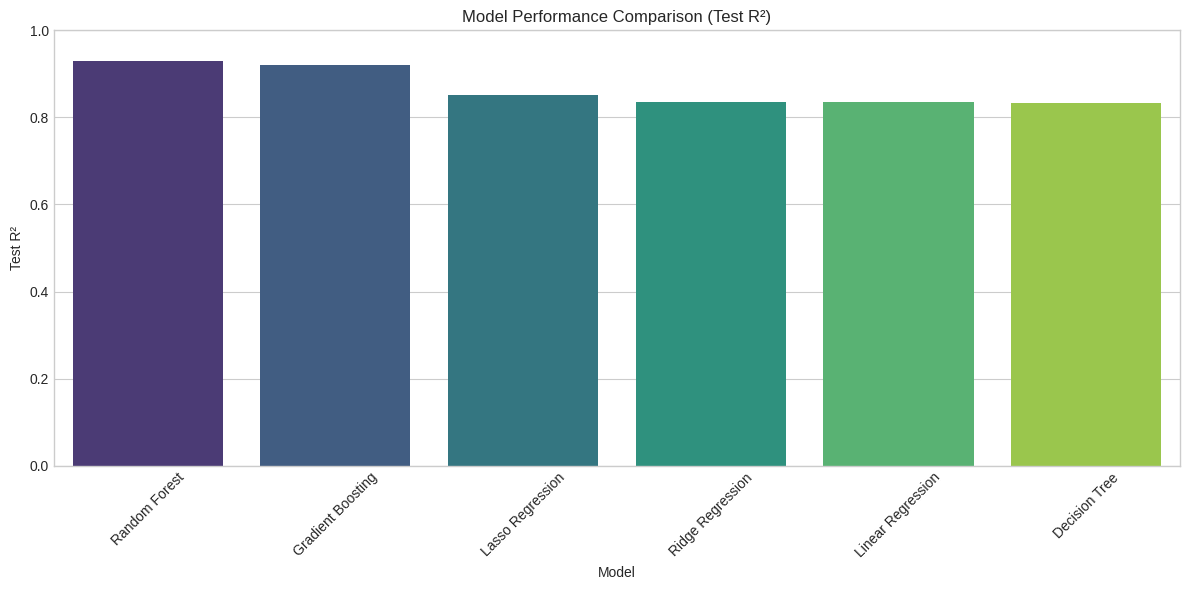


Best model: Random Forest
Test R²: 0.9298
Test RMSE: 0.2686


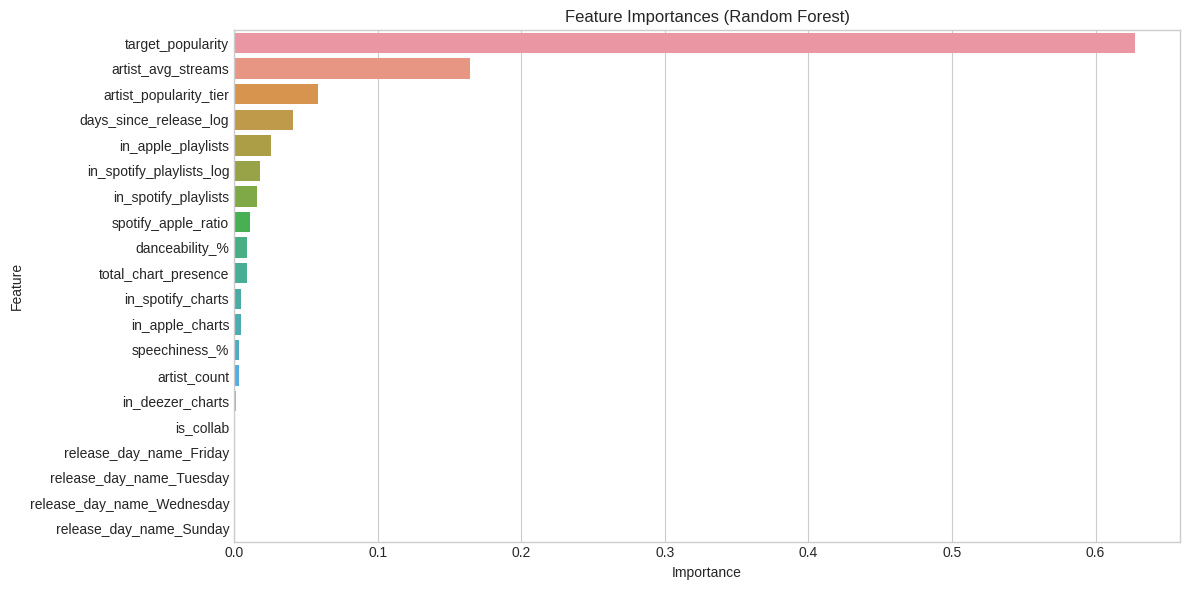


Top 10 most important features:
                     Feature  Importance
0          target_popularity    0.627427
2         artist_avg_streams    0.164648
6     artist_popularity_tier    0.058587
5     days_since_release_log    0.040759
4         in_apple_playlists    0.026030
1   in_spotify_playlists_log    0.017895
3       in_spotify_playlists    0.016293
18       spotify_apple_ratio    0.011193
19            danceability_%    0.009149
16      total_chart_presence    0.008687


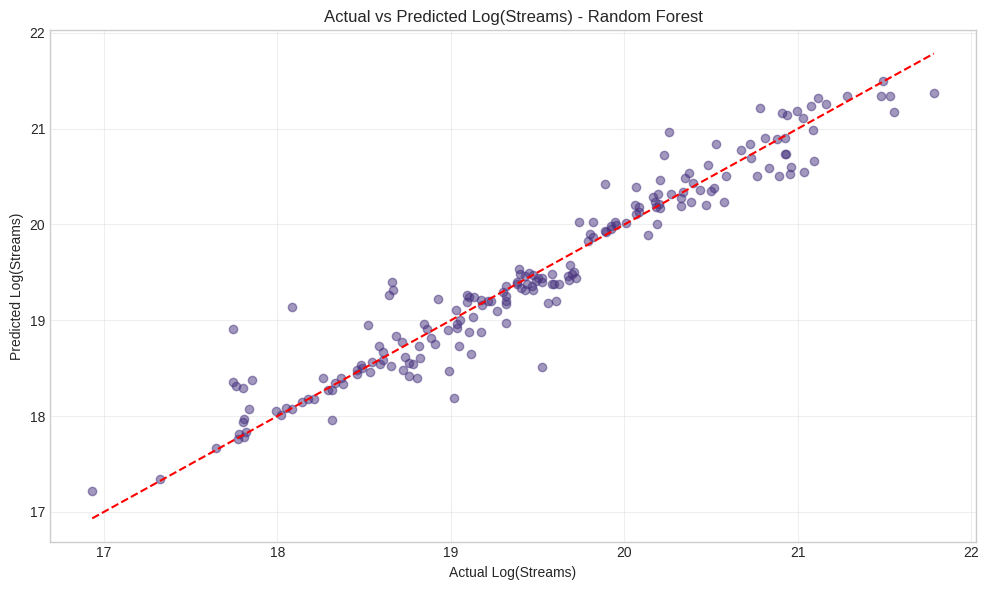

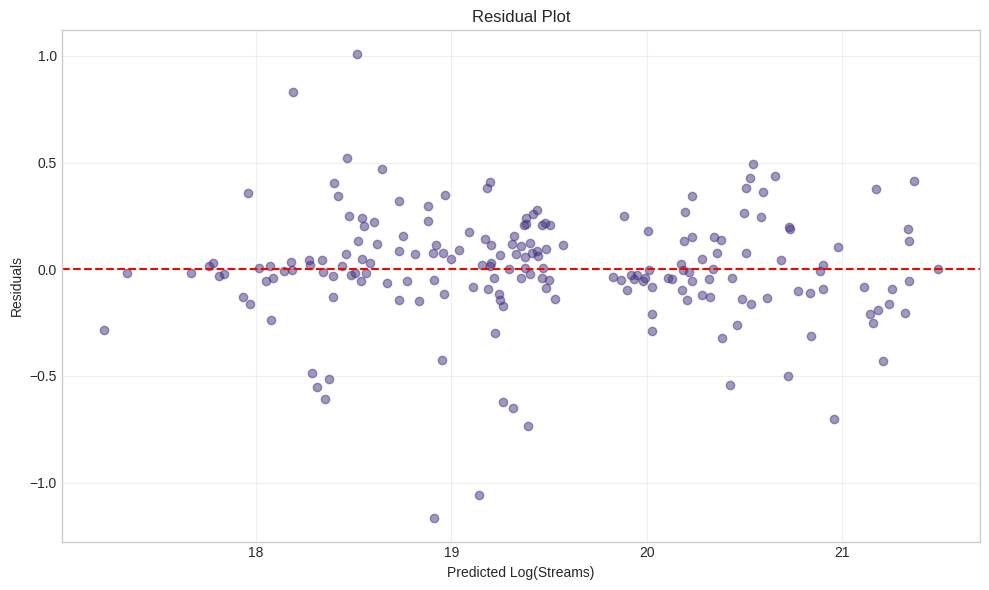


Performing hyperparameter tuning for Random Forest...
Best parameters: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best CV R²: 0.8948
Tuned model Test R²: 0.9306
Tuned model Test RMSE: 0.2670
The tuned model performs better than the original model.


In [9]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV

# 1. Define regression models
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# 2. Function to train and evaluate regression models
def evaluate_regression_model(name, model, X_train, X_test, y_train, y_test):
    # Create pipeline with preprocessing
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    
    return {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'pipeline': pipeline
    }

# 3. Train and evaluate all models
results = {}
for name, model in regression_models.items():
    print(f"Training {name}...")
    results[name] = evaluate_regression_model(name, model, X_train, X_test, y_reg_train, y_reg_test)
    print(f"  Train R²: {results[name]['train_r2']:.4f}")
    print(f"  Test R²: {results[name]['test_r2']:.4f}")
    print(f"  Test RMSE: {results[name]['test_rmse']:.4f}")
    print(f"  CV R²: {results[name]['cv_mean']:.4f} ± {results[name]['cv_std']:.4f}")
    print("")

# 4. Create a results table
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train R²': [results[model]['train_r2'] for model in results],
    'Test R²': [results[model]['test_r2'] for model in results],
    'Test RMSE': [results[model]['test_rmse'] for model in results],
    'CV R²': [results[model]['cv_mean'] for model in results],
    'CV Std': [results[model]['cv_std'] for model in results]
})

# Sort by test R² (descending)
results_df = results_df.sort_values('Test R²', ascending=False).reset_index(drop=True)
print("Model Comparison:")
print(results_df)

# 5. Visualize model performance
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Test R²', data=results_df)
plt.title('Model Performance Comparison (Test R²)')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 6. Identify the best model
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['pipeline']
print(f"\nBest model: {best_model_name}")
print(f"Test R²: {results[best_model_name]['test_r2']:.4f}")
print(f"Test RMSE: {results[best_model_name]['test_rmse']:.4f}")

# 7. Feature importance for the best model (if applicable)
if best_model_name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
    model = best_model.named_steps['model']
    importances = model.feature_importances_
    
    # Create a DataFrame for visualizing feature importances
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Feature Importances ({best_model_name})')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 most important features:")
    print(importance_df.head(10))

# 8. Actual vs Predicted plot for the best model
plt.figure(figsize=(10, 6))
y_pred = best_model.predict(X_test)
plt.scatter(y_reg_test, y_pred, alpha=0.5)
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--')
plt.xlabel('Actual Log(Streams)')
plt.ylabel('Predicted Log(Streams)')
plt.title(f'Actual vs Predicted Log(Streams) - {best_model_name}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 9. Residual plot
plt.figure(figsize=(10, 6))
residuals = y_reg_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Log(Streams)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 10. Hyperparameter tuning for the best model
if best_model_name == 'Random Forest':
    print("\nPerforming hyperparameter tuning for Random Forest...")
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10]
    }
    
    grid_search = GridSearchCV(
        best_model,
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_reg_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV R²: {grid_search.best_score_:.4f}")
    
    # Evaluate the tuned model
    tuned_model = grid_search.best_estimator_
    y_pred_tuned = tuned_model.predict(X_test)
    r2_tuned = r2_score(y_reg_test, y_pred_tuned)
    rmse_tuned = np.sqrt(mean_squared_error(y_reg_test, y_pred_tuned))
    
    print(f"Tuned model Test R²: {r2_tuned:.4f}")
    print(f"Tuned model Test RMSE: {rmse_tuned:.4f}")
    
    if r2_tuned > results[best_model_name]['test_r2']:
        print("The tuned model performs better than the original model.")
        best_model = tuned_model
    else:
        print("The original model performs better than the tuned model.")

<div style="background-color: #d9edf7; border-left: 6px solid #31708f; padding: 15px; font-family: Arial, sans-serif;">
    <h2 style="text-align: center; color: #3c3c3c;">
        🚀 Found my analysis and notebook useful? 
    </h2>
    <p style="text-align: center; color: #555;">
        Your feedback would mean the world! 💬 If my work has been helpful, please consider dropping a comment and an upvote. 
        <strong>Your support fuels my drive to create even better insights! 🌟</strong>
    </p>
</div>